In [5]:
import csv 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image

def process_img(img):
    # This function is intended to process the images and eliminate any irrelevent features
    # the offroad features and apply YUV color transformation 

    # Guassian blur applied here to add more generalization to the data, and prevent overfitting
    #img = cv2.GaussianBlur(img, (3,3), 0) // removed after adding dropouts 
    
    # image converted to YUV color space (Similar to Nvidia project )
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img


In [6]:
## Function that loads and returns images and measurements 

def load_data(folder_name):
    car_images=[]
    steering_angles=[]
    with open(folder_name+'/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            steering_center = float(row[3])

            # create adjusted steering measurements for the side camera images
            correction = 0.1 # this is a parameter to tune
            steering_left = steering_center + correction
            steering_right = steering_center - correction

            # read in images from center, left and right cameras
            path = folder_name+'/'  # fill in the path to your training IMG directory
            row0=row[0].split('IMG')[-1]
            row1=row[1].split('IMG')[-1]
            row2=row[2].split('IMG')[-1]
            img_center = process_img(np.asarray(Image.open(path + 'IMG/'+row0)))
            img_left = process_img(np.asarray(Image.open(path + 'IMG/'+ row1.strip())))
            img_right = process_img(np.asarray(Image.open(path + 'IMG/'+ row2.strip())))

            # add images and angles to data set
            car_images.append(img_center)
            car_images.append(img_left)
            car_images.append(img_right)
            
            steering_angles.append(steering_center)
            steering_angles.append( steering_left)
            steering_angles.append(steering_right)
        
    return car_images,steering_angles



In [7]:
print('Done')

Done


In [8]:


## Loading data and combining all  
total_images=[]
total_measurements=[]
images=[]
measurements=[]
print('\n Loading images...')
# Load and store the given data,, due to the high number of data this data was not needed anymore
imgg,meas=load_data('data')
for image,measurement in zip(imgg,meas):
    images.append(image)
    measurements.append(measurement)

# Load and append the First training (3 Labs)
imgg,meas=load_data('mydata')
for image,measurement in zip(imgg,meas):
    images.append(image)
    measurements.append(measurement)


# Load and append the Second Training data (Opposite Two Labs)
imgg,meas=load_data('mydata_oppos')
for image,measurement in zip(imgg,meas):
    images.append(image)
    measurements.append(measurement)

# Load and append the Third Training data (Avoiding dirty Roads, 6 times)
imgg,meas=load_data('mydata_avoid_dirt')
for image,measurement in zip(imgg,meas):
    images.append(image)
    measurements.append(measurement)


for (image, measurement) in zip(images,measurements):
    total_images.append(image)
    total_measurements.append(measurement)

    total_images.append(cv2.flip(image,1))
    total_measurements.append(measurement*-1.0)

    
X_train=np.array(total_images)
y_train=np.array(total_measurements)


#X_train=np.asarray(X_train).astype(np.float32)
#y_train=np.asarray(y_train).astype(np.float32)

print("The number of Data to be trained is ",len(X_train))
print(len(y_train))



 Loading images...
The number of Data to be trained is  117084
117084


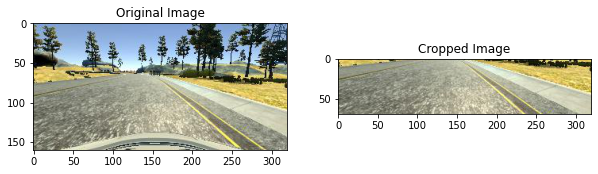

In [12]:
## Example of processing image Cropping

test_img=imgg[0]

#test_img = cv2.cvtColor(test_img, cv2.COLOR_YUV2BGR)

fig, ax=plt.subplots(1,2,figsize=(10,10))


ax[0].imshow(test_img)
ax[0].set_title('Original Image')
ax[1].imshow(test_img[65:135,:,:])
ax[1].set_title('Cropped Image')

plt.savefig('./Plots/Image_Processed.png', bbox_inches = 'tight')


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D as Conv2D
from keras.layers import Lambda, Cropping2D, MaxPooling2D
from keras.optimizers import Adam

def nvidia_model():
    model = Sequential()
    
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

    # eliminate offroad features
    model.add(Cropping2D(cropping=((60,25),(0,0)))) 
    
    model.add(Conv2D(24,(5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))

    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(MaxPooling2D())

    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))
    
    model.add(Dropout(0.25))

    model.add(Dense(50, activation = 'elu'))
    
    #model.add(Dropout(0.5))

    model.add(Dense(10, activation = 'elu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(1))

    Optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=Optimizer)
    return model
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 33, 64)         3

Epoch 1/7
2745/2745 [==============================] - 107s 27ms/step - loss: 0.0170 - val_loss: 0.0211
Epoch 2/7
2745/2745 [==============================] - 70s 25ms/step - loss: 0.0108 - val_loss: 0.0196
Epoch 3/7
2745/2745 [==============================] - 71s 26ms/step - loss: 0.0102 - val_loss: 0.0198
Epoch 4/7
2745/2745 [==============================] - 69s 25ms/step - loss: 0.0106 - val_loss: 0.0201
Epoch 5/7
2745/2745 [==============================] - 69s 25ms/step - loss: 0.0102 - val_loss: 0.0200
Epoch 6/7
2745/2745 [==============================] - 69s 25ms/step - loss: 0.0100 - val_loss: 0.0197
Epoch 7/7
2745/2745 [==============================] - 70s 26ms/step - loss: 0.0095 - val_loss: 0.0184
dict_keys(['loss', 'val_loss'])


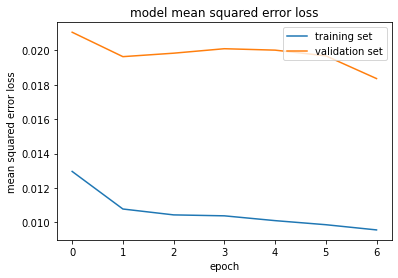

In [11]:
history_object=model.fit(X_train,y_train,validation_split=0.25, shuffle=True,epochs=7,verbose = 1)
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

plt.savefig('./Plots/Model_MSE_Loss.png', bbox_inches = 'tight')
model.save('model.h5')

# Archive 

In [ ]:

def load_data(folder_name):
    lines = []

    with open(folder_name +'/driving_log.csv')  as csvfile:
        reader=csv.reader(csvfile)
        next(reader)
        for line in reader:
            lines.append(line)
        
    images=[]
    measurements=[]
    
    # Gathered from data folder
    for line in lines:
        source_path=line[0]
        filename=source_path.split('IMG')[-1]
        current_path=folder_name +'/IMG/' +filename
        image2=cv2.imread(current_path)
        img=process_img(image2)
        images.append(img)
        measurement=float(line[3])
        measurements.append(measurement)

    return images,measurements
    